## Query Processing Experiment

In [1]:
import functools
import pickle
from ast import literal_eval

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns

from dataset_configuration.airbnb.experiment_scripts.aqp_queries import airbnb_aqp_queries
from dataset_configuration.imdb.experiment_scripts.aqp_queries import imdb_aqp_queries
from evaluation.approximate_query_processing.aqp_queries import Aggregation
from evaluation.notebook_utils.bar_plots import shared_bar_plots, FontSizes
from evaluation.notebook_utils.combine_files import combine_files
from evaluation.notebook_utils.evaluation_columns import eval_column, Metric
from evaluation.notebook_utils.plotting_query import PlottingQuery


plt.rc('text', usetex=True)

default_alpha = 0.7
figsize = (15,2)

colors = [
    sns.color_palette()[0],
    sns.color_palette()[1],
    sns.color_palette()[3],
    "#34495e"
]
large_fonts = FontSizes(ticks=14, legend=14, labels=14,subtitle=14, bar_labels=10)
formatter = mtick.PercentFormatter(xmax=1, decimals=1, symbol='%', is_latex=False)

In [2]:
combine_files('experiment_data/exp_aqp_airbnb/part*', 'experiment_data/exp_aqp_airbnb/exp_aqp.csv')
combine_files('experiment_data/exp_aqp_imdb/part*', 'experiment_data/exp_aqp_imdb/exp_aqp.csv')

Combining 3968 files
Combining 5632 files


In [3]:
df_exp = pd.concat([
    pd.read_csv('experiment_data/exp_aqp_airbnb/exp_aqp.csv'),
    pd.read_csv('experiment_data/exp_aqp_imdb/exp_aqp.csv'),
])

for m in [Metric.QP_IMPROVEMENT]:
    print(f'Adding {m}')
    df_exp[str(m)] = df_exp.apply(lambda r: eval_column(r, metric=m), axis=1)

df_exp.removal_attr = df_exp.apply(lambda r: literal_eval(r.removal_attr)[0], axis=1)
df_exp.removal_attr_bias = df_exp.apply(lambda r: literal_eval(r.removal_attr_bias)[0], axis=1)
df_exp.tuple_removal_keep_rate = df_exp.apply(lambda r: literal_eval(r.tuple_removal_keep_rate)[0], axis=1)
df_exp['completion_table_list'] = df_exp.apply(lambda r: set(literal_eval(r.completion_tables)), axis=1)

removal_attrs_airbnb = ['listings.price', 'listings.room_type', 'listings.property_type', 'hosts.host_since', 'hosts.host_response_rate']
removal_attrs_imdb = ['movie.production_year', 'movie.genre', 'movie.country', 'director.birth_year', 'company.country_code']
removal_attrs = set(removal_attrs_airbnb).union(removal_attrs_imdb)

df_exp['improvement'] = 0

Adding qp_improvement


In [4]:
with open('../research-data/incomplete-db/airbnb/hdf_preprocessed/meta_data.pkl', 'rb') as handle:
    airbnb_meta_data = pickle.load(handle)
with open('../research-data/incomplete-db/imdb/hdf_preprocessed/meta_data.pkl', 'rb') as handle:
    imdb_meta_data = pickle.load(handle)

general_value_dict = {}
def merge_value_dict(general_value_dict, meta_data):
    for t in meta_data.values():
        for attribute_name, value_dict in t['categorical_columns_dict'].items():
            inv_dict = {v:k for k,v in value_dict.items()}
            general_value_dict[attribute_name] = inv_dict
merge_value_dict(general_value_dict, airbnb_meta_data)
merge_value_dict(general_value_dict, imdb_meta_data)
del general_value_dict['hosts.host_response_time']

qp_queries = []
qp_query_dict = dict()
for dataset_queries in [airbnb_aqp_queries, imdb_aqp_queries]:
    for attribute, queries in dataset_queries.items():
        for id, query in queries.items():
            for aggregation in Aggregation:
                if attribute not in removal_attrs:
                    continue
                if aggregation != Aggregation.COUNT and query.aggregation_attribute is None:
                    continue
                query_object = PlottingQuery(id, attribute, aggregation, query, general_value_dict)
                qp_queries.append(query_object)
                qp_query_dict[(attribute, id, aggregation)] = query_object

print(len(qp_queries))

34


In [7]:
def extract_improvement(row, query=None):
    improvements = row['qp_improvement']
    if query.id not in improvements.keys():
        print(f'Query {query.id} not provided in row')
        return 0

    improvements = improvements[query.id]

    improvement = 0
    if query.aggregation == Aggregation.COUNT:
        improvement = improvements[0]
    elif query.aggregation == Aggregation.AVG:
        improvement = improvements[1]
    elif query.aggregation == Aggregation.SUM:
        improvement = improvements[2]
    return improvement

def y_aqp_improvement(series_idx, plot_idx, queries=None, df_exp=None, keep_rates=None, **kwargs):
    query = queries[plot_idx]
    keep_rate = keep_rates[series_idx]

    df_current = df_exp
    df_current = df_current[df_current.tuple_removal_keep_rate == keep_rate]
    df_current = df_current[df_current.removal_attr == query.attribute]
    df_current = df_current[df_current.completion_table_list == query.completion_tables]

    df_current = df_current[['qp_improvement', 'removal_attr_bias']]
    improvements =  df_current.apply(functools.partial(extract_improvement, query=query), axis=1)
    try:
        df_current['improvement'] = improvements
        df_current = df_current[['improvement', 'removal_attr_bias']].groupby(['removal_attr_bias']).max().reset_index()
        df_current = df_current.sort_values(['removal_attr_bias'])

        return df_current['improvement']

    except:
        print(improvements)
        print(df_current)
        print(f'Problem evaluating query {query.id}')
        # df_current['improvement'] = 0

    return [0, 0, 0, 0]

df_qp = df_exp[(df_exp.model_selection_strategy == 'none') &
                            (df_exp.not_synthetic == True)
                            ]

## Query Processing


Housing & $H_1$ & $Q_{1}$ & \texttt{SELECT SUM(price) FROM apartment WHERE room\_type='Entire home/apt';} \\
Housing & $H_2$ & $Q_{2}$ & \texttt{SELECT COUNT(*) FROM apartment WHERE room\_type='Entire home/apt' AND property\_type='House' GROUP BY property\_type;} \\
Housing & $H_3$ & $Q_{3}$ & \texttt{SELECT COUNT(*) FROM apartment WHERE property\_type='House';} \\
Housing & $H_4$ & $Q_{4}$ & \texttt{SELECT COUNT(*) FROM landlord WHERE landlord\_since$\ge$2011;} \\
Housing & $H_5$ & $Q_{5}$ & \texttt{SELECT AVG(landlord\_response\_rate) FROM landlord WHERE landlord\_response\_time$\ge$2;} \\
Housing & $H_1$ & $Q_{6}$ & \texttt{SELECT AVG(price) FROM landlord NATURAL JOIN apartment WHERE room\_type='Entire home/apt' GROUP BY landlord\_since;} \\
Housing & $H_2$ & $Q_{7}$ & \texttt{SELECT COUNT(*) FROM landlord NATURAL JOIN apartment WHERE accommodates$\ge$3 GROUP BY landlord\_since;} \\
Housing & $H_3$ & $Q_{8}$ & \texttt{SELECT COUNT(*) FROM landlord NATURAL JOIN apartment WHERE landl

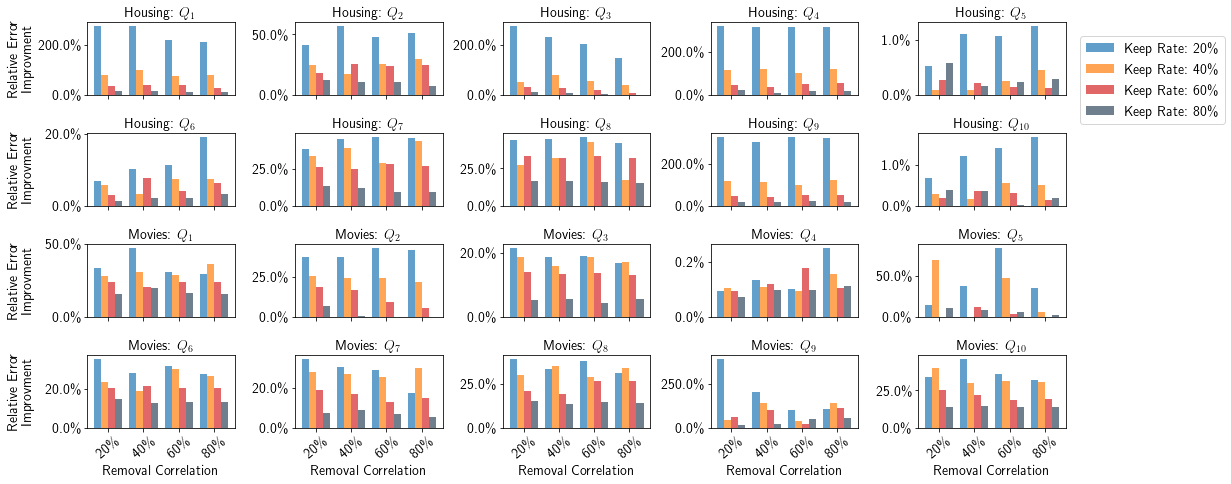

In [8]:
def setup_id(attribute):
    if attribute in removal_attrs_airbnb:
        return removal_attrs_airbnb.index(attribute) + 1
    if attribute in removal_attrs_imdb:
        return removal_attrs_imdb.index(attribute) + 1
    return 0

def plot_aqp_queries(queries, dataset, path, df_exp):
    curr_aqp_queries = queries
    print()
    for i, q in enumerate(curr_aqp_queries):
        sstr = q.paper_formatted_sql_string()
        print(f"{dataset[i]} & ${dataset[i][0]}_{setup_id(q.attribute)}$ & $Q_{{{(i%10+1)}}}$ & \\texttt{{{sstr}}} \\\\")
    print()

    shared_bar_plots(no_plots=len(curr_aqp_queries), series_per_plot=4, y_data=y_aqp_improvement, font_sizes=large_fonts,
                 ncols=5, width=0.2, labels=[f'Keep Rate: {keep_rate*100:.0f}\%' for keep_rate in [0.2, 0.4, 0.6, 0.8]],
                 titles=[f'{dataset[i]}: $Q_{{{(i%10+1)}}}$' for i,q in enumerate(curr_aqp_queries)],
                 xticklabels=['20\%', '40\%', '60\%', '80\%'], keep_rates=[0.2, 0.4, 0.6, 0.8],
                 y_label='Relative Error\n Improvment', x_label='Removal Correlation', figsize=(15,6), df_exp=df_exp,
                 default_alpha=default_alpha, colors=colors, queries=curr_aqp_queries,
                 y_ax_formatter=formatter, sharey='none', save_path=path, x_tick_rotation=40, x_tick_bottom=0.0,
                 x_tick_ha='center', legend=True, legend_bbox_to_anchor=(1.05, 5.5))

df_exp = df_qp
queries = [qp_query_dict[('listings.price', 1, Aggregation.SUM)],
            qp_query_dict[('listings.room_type', 0, Aggregation.COUNT)],
            qp_query_dict[('listings.property_type', 1, Aggregation.COUNT)],
            qp_query_dict[('hosts.host_since', 2, Aggregation.COUNT)],
            qp_query_dict[('hosts.host_response_rate', 1, Aggregation.AVG)],
            qp_query_dict[('listings.price', 7, Aggregation.AVG)],
            qp_query_dict[('listings.room_type', 5, Aggregation.COUNT)],
            qp_query_dict[('listings.property_type', 3, Aggregation.COUNT)],
            qp_query_dict[('hosts.host_since', 6, Aggregation.SUM)],
            qp_query_dict[('hosts.host_response_rate', 6, Aggregation.AVG)],
            qp_query_dict[('movie.production_year', 1, Aggregation.COUNT)],
            qp_query_dict[('movie.genre', 0, Aggregation.COUNT)],
            qp_query_dict[('movie.country', 2, Aggregation.COUNT)],
            qp_query_dict[('director.birth_year', 0, Aggregation.AVG)],
            qp_query_dict[('company.country_code', 1, Aggregation.COUNT)],
            qp_query_dict[('movie.production_year', 4, Aggregation.SUM)],
            qp_query_dict[('movie.genre', 5, Aggregation.COUNT)],
            qp_query_dict[('movie.country', 4, Aggregation.COUNT)],
            qp_query_dict[('director.birth_year', 4, Aggregation.COUNT)],
            qp_query_dict[('movie.genre', 4, Aggregation.COUNT)]]
plot_aqp_queries(queries, ['Housing']*10 + ['Movies']*10, 'experiment_data/plots/query_proc.pdf', df_exp)